In [1]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras for feature extraction
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


In [2]:
# Load MobileNetV2 feature extractor (remove final classification layer)
feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

def extract_feature(img_path):
    """Extract 1280-d MobileNetV2 features for a single image."""
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = feature_model.predict(img_array, verbose=0)
    return feature.flatten()


C:\Users\nohas\AppData\Local\Temp\ipykernel_25444\1752673092.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


In [4]:
def process_folder(base_path):
    X_features, y_stage1, y_class = [], [], []

    for category in ["fruit", "vegetable"]:
        category_path = os.path.join(base_path, category)
        for class_name in os.listdir(category_path):
            class_path = os.path.join(category_path, class_name)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    feature = extract_feature(img_path)
                    X_features.append(feature)
                    y_stage1.append(0 if category == "fruit" else 1)
                    y_class.append(class_name)
                except Exception as e:
                    print("Error loading:", img_path, e)

    return np.array(X_features), np.array(y_stage1), np.array(y_class)

# Example paths
train_dir = r"C:\final projects\semester 7\MLproject\fruit_veg_classifier\train"
test_dir = r"C:\final projects\semester 7\MLproject\fruit_veg_classifier\test"

# Extract features
X_train, y_train_stage1, y_train_class = process_folder(train_dir)
X_test, y_test_stage1, y_test_class = process_folder(test_dir)

# Save features for reuse
np.save("X_train.npy", X_train)
np.save("y_train_stage1.npy", y_train_stage1)
np.save("y_train_class.npy", y_train_class)
np.save("X_test.npy", X_test)
np.save("y_test_stage1.npy", y_test_stage1)
np.save("y_test_class.npy", y_test_class)

print("Train features:", X_train.shape)
print("Test features:", X_test.shape)


Train features: (3115, 1280)
Test features: (359, 1280)


In [5]:
# Split training data into train + validation
X_train_dt, X_val_dt, y_train_dt, y_val_dt = train_test_split(
    X_train, y_train_stage1, test_size=0.2, random_state=42, stratify=y_train_stage1
)

print("Training set:", X_train_dt.shape)
print("Validation set:", X_val_dt.shape)


Training set: (2492, 1280)
Validation set: (623, 1280)


In [6]:
# Stage 1: Fruit vs Vegetable
stage1_dt = DecisionTreeClassifier(random_state=42)
stage1_dt.fit(X_train_dt, y_train_dt)

# Evaluate on validation
y_val_pred = stage1_dt.predict(X_val_dt)
print("=== Stage 1 Validation ===")
print("Accuracy:", accuracy_score(y_val_dt, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_dt, y_val_pred))
print("Classification Report:\n", classification_report(y_val_dt, y_val_pred, target_names=["Fruit","Vegetable"]))

# Save model
joblib.dump(stage1_dt, "stage1_dt_model.pkl")


=== Stage 1 Validation ===
Accuracy: 0.8154093097913323
Confusion Matrix:
 [[ 77  59]
 [ 56 431]]
Classification Report:
               precision    recall  f1-score   support

       Fruit       0.58      0.57      0.57       136
   Vegetable       0.88      0.89      0.88       487

    accuracy                           0.82       623
   macro avg       0.73      0.73      0.73       623
weighted avg       0.81      0.82      0.81       623



['stage1_dt_model.pkl']

In [7]:
# Stage 2: Fruit and Vegetable types
# Subset training data
fruit_idx = np.where(y_train_stage1 == 0)[0]
veg_idx = np.where(y_train_stage1 == 1)[0]

X_train_fruit = X_train[fruit_idx]
y_train_fruit = y_train_class[fruit_idx]

X_train_veg = X_train[veg_idx]
y_train_veg = y_train_class[veg_idx]

# Train Decision Trees
fruit_dt = DecisionTreeClassifier(random_state=42)
fruit_dt.fit(X_train_fruit, y_train_fruit)
joblib.dump(fruit_dt, "fruit_dt_model.pkl")

veg_dt = DecisionTreeClassifier(random_state=42)
veg_dt.fit(X_train_veg, y_train_veg)
joblib.dump(veg_dt, "veg_dt_model.pkl")

print("Stage 2 Decision Trees trained and saved")


Stage 2 Decision Trees trained and saved


In [8]:
def test_full_pipeline(base_folder, display_images=False, max_display=5):
    y_true_stage1, y_pred_stage1 = [], []
    y_true_stage2, y_pred_stage2 = [], []

    display_count = 0

    for root, dirs, files in os.walk(base_folder):
        img_files = [f for f in files if f.lower().endswith(('.png','.jpg','.jpeg'))]
        if len(img_files) == 0:
            continue

        features_list, true_stage2_labels = [], []

        # Parent folder determines Stage 1 label
        parent_folder = os.path.basename(os.path.dirname(root)).lower()
        true_stage1_label = 0 if parent_folder == "fruit" else 1

        for img_file in img_files:
            img_path = os.path.join(root, img_file)
            features_list.append(extract_feature(img_path))
            true_stage2_labels.append(os.path.basename(root))  # Type label
            y_true_stage1.append(true_stage1_label)

        features_batch = np.array(features_list)
        stage1_preds = stage1_dt.predict(features_batch)

        for i, img_file in enumerate(img_files):
            y_pred_stage1.append(stage1_preds[i])

            if stage1_preds[i] == 0:
                pred_type = fruit_dt.predict(features_batch[i].reshape(1,-1))[0]
            else:
                pred_type = veg_dt.predict(features_batch[i].reshape(1,-1))[0]

            y_pred_stage2.append(pred_type)
            y_true_stage2.append(true_stage2_labels[i])

            if display_images and display_count < max_display:
                img_display = load_img(os.path.join(root,img_file))
                plt.imshow(img_display)
                plt.axis('off')
                plt.show()
                print(f"Image: {img_file}")
                print(f"Predicted Stage 1: {'Fruit' if stage1_preds[i]==0 else 'Vegetable'}")
                print(f"Predicted Stage 2: {pred_type}")
                print(f"True label: {true_stage2_labels[i]}")
                print("-"*40)
                display_count += 1

    # Stage 1 evaluation
    print("=== Stage 1 (Fruit vs Vegetable) ===")
    print("Accuracy:", accuracy_score(y_true_stage1, y_pred_stage1))
    print("Confusion Matrix:\n", confusion_matrix(y_true_stage1, y_pred_stage1))
    print("Classification Report:\n", classification_report(y_true_stage1, y_pred_stage1, target_names=["Fruit","Vegetable"]))

    # Stage 2 evaluation
    print("\n=== Stage 2 (Specific Type) ===")
    print("Accuracy:", accuracy_score(y_true_stage2, y_pred_stage2))
    print("Confusion Matrix:\n", confusion_matrix(y_true_stage2, y_pred_stage2))
    print("Classification Report:\n", classification_report(y_true_stage2, y_pred_stage2))


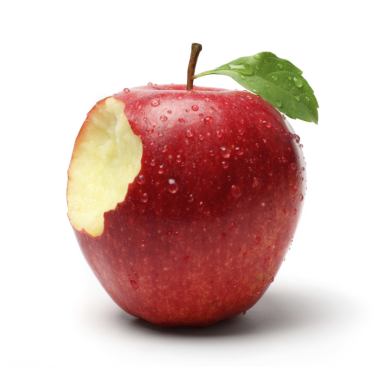

Image: Image_1.jpg
Predicted Stage 1: Fruit
Predicted Stage 2: apple
True label: apple
----------------------------------------


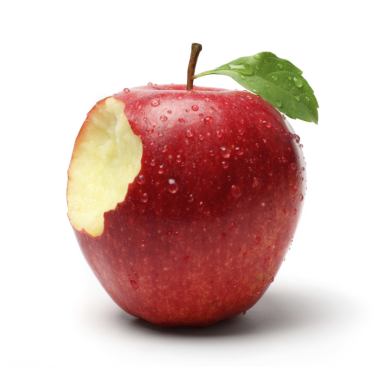

Image: Image_10.jpg
Predicted Stage 1: Fruit
Predicted Stage 2: apple
True label: apple
----------------------------------------


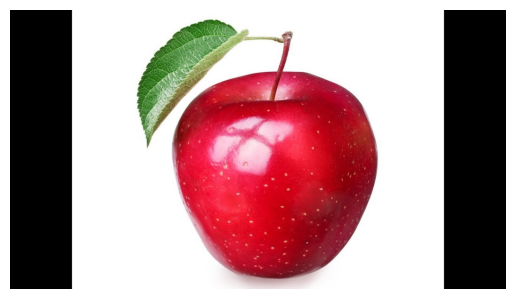

Image: Image_2.jpg
Predicted Stage 1: Fruit
Predicted Stage 2: apple
True label: apple
----------------------------------------


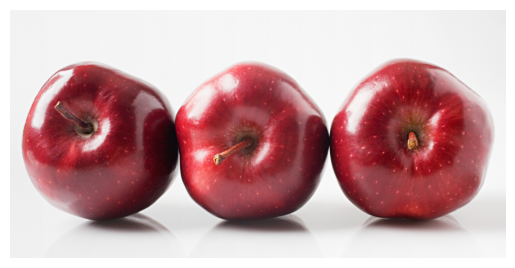

Image: Image_3.jpg
Predicted Stage 1: Fruit
Predicted Stage 2: apple
True label: apple
----------------------------------------


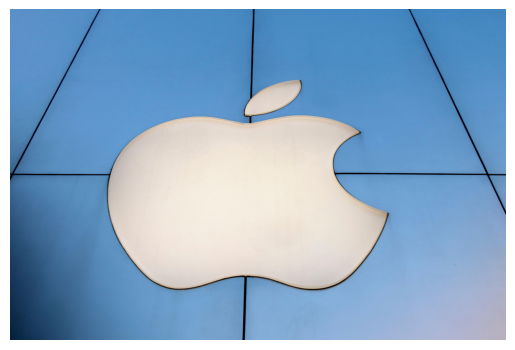

Image: Image_4.jpg
Predicted Stage 1: Vegetable
Predicted Stage 2: peas
True label: apple
----------------------------------------
=== Stage 1 (Fruit vs Vegetable) ===
Accuracy: 0.935933147632312
Confusion Matrix:
 [[ 71  18]
 [  5 265]]
Classification Report:
               precision    recall  f1-score   support

       Fruit       0.93      0.80      0.86        89
   Vegetable       0.94      0.98      0.96       270

    accuracy                           0.94       359
   macro avg       0.94      0.89      0.91       359
weighted avg       0.94      0.94      0.93       359


=== Stage 2 (Specific Type) ===
Accuracy: 0.947075208913649
Confusion Matrix:
 [[ 6  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  8]]
Classification Report:
                precision    recall  f1-score   support

        apple       1.00      0.60      0.75        10
       banana       0.88      0.78      

In [9]:
test_full_pipeline(r"C:\final projects\semester 7\MLproject\fruit_veg_classifier\test", display_images=True, max_display=5)


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
import joblib

# Load trained models
stage1_model = joblib.load("stage1_dt_stage1.pkl")  # Decision Tree Stage 1
fruit_model = joblib.load("fruit_dt_model.pkl")     # Decision Tree Fruit Type
veg_model = joblib.load("veg_dt_model.pkl")         # Decision Tree Veg Type

# MobileNetV2 feature extractor
feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

def extract_feature(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = feature_model.predict(img_array, verbose=0)
    return feature.flatten()

def predict_folder(test_folder):
    for root, dirs, files in os.walk(test_folder):
        for img_file in files:
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(root, img_file)
            features = extract_feature(img_path).reshape(1, -1)

            # Stage 1 prediction: Fruit vs Vegetable
            stage1_pred = stage1_model.predict(features)[0]
            true_stage1 = 0 if 'fruit' in root.lower() else 1

            # Stage 2 prediction: specific type
            if stage1_pred == 0:
                type_pred = fruit_model.predict(features)[0]
            else:
                type_pred = veg_model.predict(features)[0]

            # True type from folder name
            true_type = os.path.basename(root)

            # Print results
            print(f"Image: {img_file}")
            print(f"Predicted Stage 1: {'Fruit' if stage1_pred == 0 else 'Vegetable'}")
            print(f"Predicted Stage 2: {type_pred}")
            print(f"True Stage 1: {'Fruit' if true_stage1 == 0 else 'Vegetable'}")
            print(f"True Type: {true_type}")
            print("-"*40)

# Example usage
predict_folder(r"C:\final projects\semester 7\MLproject\fruit_veg_classifier\test")


FileNotFoundError: [Errno 2] No such file or directory: 'stage1_dt_stage1.pkl'